# Project II: Economic Growth 

### By Astrid Fugleholm, Jacob Strabo, and Jørgen Høst

In [2]:
# Importing packages
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm
from numpy.matlib import repmat
import matplotlib.pyplot as plt

## 1. Read Data

In [3]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


## 2. Descriptive Plots

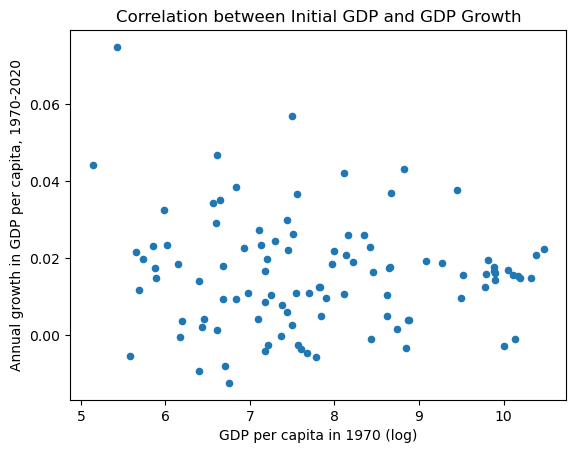

In [4]:
# Correlation between initial GDP level and GDP growth rate
fig1 = dat.plot.scatter(x='lgdp_initial', y='gdp_growth');
fig1.set_xlabel(lbl_all['lgdp_initial']);
fig1.set_ylabel(lbl_all['gdp_growth']);
fig1.set_title('Correlation between Initial GDP and GDP Growth');

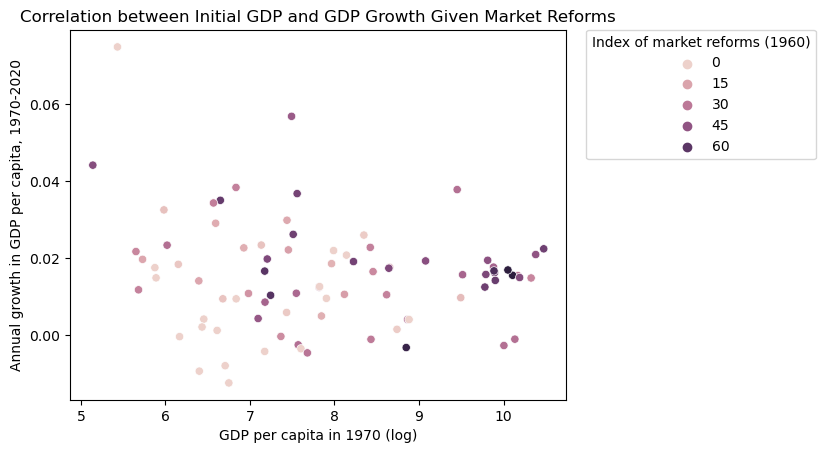

In [5]:
# Correlation between initial GDP and GDP growth with countries coloured depending on the number of market reforms implemented
fig2 = sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='marketref');
fig2.set_xlabel(lbl_all['lgdp_initial']);
fig2.set_ylabel(lbl_all['gdp_growth']);
fig2.legend(title=lbl_all['marketref'],loc=(1.04,0.65));
fig2.set_title('Correlation between Initial GDP and GDP Growth Given Market Reforms');

## 3. Collection of Variables

In order to make the analysis simpler, we collect variables in sets that belong together naturally. We do this based on all available variables, that is we have not discarded any variables deemed unnecessary yet.

In [6]:
# Variables regarding institutions
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 

# Variables regarding geography
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]

# Variables regarding genetic diversity
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']

# Variables regarding historical events
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']

# Variables regarding religion
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']

# Variables regarding the level of danger in countries
vv_danger = ['yellow', 'malfal',  'uvdamage']

# Variables regarding natural resources in countries
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']

# Variables regarding educational attainment level of populations in countries 
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

# A collection of all available variables grouped based on category
vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

In [7]:
# We also create a column of ones that can serve as our constant
dat['constant'] = np.ones((dat.shape[0],))

## 4. Simple OLS as a Starting Point

In [8]:
# Removing observations with missings 
xs = ['constant', 'lgdp_initial']
I = dat[['gdp_growth'] + xs].notnull().all(axis=1)
print(I.shape)

(214,)


In [9]:
# The outcome variable gdp_growth is available for only some of the 214 countries
dat_ = dat['gdp_growth'].dropna()
print("Outcome variable gdp_growth is available for",dat_.shape[0],"of the 214 countries.")

Outcome variable gdp_growth is available for 102 of the 214 countries.


In [10]:
# Extracting y and X from our data set 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, xs].values

In [11]:
print(y.shape)
print(X.shape)

(102, 1)
(102, 2)


### 4.1 Simple OLS without Controls

In [12]:
# Run a simple OLS without any controls as a starting point
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 2.24792211]
 [-0.08713416]]


In [13]:
# Reporting the results from the simple OLS estimation without any controls in a table
tab = pd.DataFrame({'beta': betahat.flatten()}, index=xs)
tab

,beta
constant,2.247922
lgdp_initial,-0.087134


The results from running a simple OLS regression of initial GDP in 1970 on GDP growth in 1970-2020 suggest that having a 1 pct. higher initial GDP decreases annual growth in GDP per capita growth by $0.09/100=0.0009$ pct. Or put differently, having a 1 pct. lower initial GDP will have increase annual growth in GDP per capita by $0.0009$ pct. 

### 4.2 Simple OLS with Controls

In [14]:
vs_ols = vv_all['geography'] + vv_all['religion']
xs_ols = ['constant', 'lgdp_initial', 'pop_growth', 'investment_rate'] + vs_ols

# avoiding missings
all_vars = ['gdp_growth'] + xs_ols
I = dat[all_vars].notnull().all(1)

# extract data
X_ols = dat.loc[I, xs_ols].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# check the rank condition
K = X_ols.shape[1]
assert np.linalg.matrix_rank(X_ols) == X_ols.shape[1], f'X_ols does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X_ols.T @ X_ols) @ X_ols.T @ y

In [15]:
print(xs_ols)
print(X_ols.shape)

['constant', 'lgdp_initial', 'pop_growth', 'investment_rate', 'tropicar', 'distr', 'distcr', 'distc', 'suitavg', 'temp', 'suitgini', 'elevavg', 'elevstd', 'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough', 'landlock', 'africa', 'asia', 'oceania', 'americas', 'pprotest', 'pcatholic', 'pmuslim']
(89, 28)


In [16]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'betahat': betas[:,0]}, index=xs_ols).round(3)

Mean y =  1.52% growth per year


,betahat
constant,18.405
lgdp_initial,-1.118
pop_growth,6.830
investment_rate,0.068
tropicar,-0.411
distr,-0.000
distcr,0.001
distc,-0.003
suitavg,-1.063
temp,-0.204


Results from running a simple OLS regression using various controls suggest that the negative effect from initial GDP on annual growth in GDP per capita is even larger when controlling for characteristics such as a country's capital formation, the share of land area in geographical tropics in a country, the population's religious affiliation, which continent the country is placed on, etc. The table above shows that having a 1 pct. lower initial GDP in 1970 increases annual growth in GDP per capita by $1.118/100=0.0118$ pct. The table also shows that some of the characteristics have relatively large impacts on the annual growth in GDP per capita; these include the annual population growth rate, land suitability for agriculture, mean elevation, terrain roughness, as well as being a country situated in either Africa, Asia, Oceania, or America. In particular, the coefficient on the dummy variable for being a country in Africa is $-2.354$ which means that being a country in Africa lowers annual GDP growth rate by $-2.345/100=-0.02$ pct. This shows that there may be other characteristics than initial GDP in 1970 determining the annual growth rate in GDP per capita implying that the simple OLS regression without controls suffers from omitted variable bias. 

## 5. Initial Selection of Controls

Ex ante, certain characteristics seem more important for predicting annual growth in GDP per capita. Before proceeding with our estimations using smarter methods, we therefore discard some of the available variables which we believe will be unimportant in our predictions. Part of our choice of variables hinges on the number of countries for which these variables are observed as a variable will have lower predictive power the fewer countries this information exists for. 

In [17]:
# Variables regarding institutions
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'democ00a', 'democ1', 'demreg'] 

# Variables regarding geography
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]

# Variables regarding genetic diversity
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']

# Variables regarding historical events
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']

# Variables regarding religion
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']

# Variables regarding the level of danger in countries
vv_danger = ['yellow', 'malfal',  'uvdamage']

# Variables regarding natural resources in countries
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']

# Variables regarding educational attainment level of populations in countries 
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

# A collection of all available variables grouped based on category
vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'educ':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

In [18]:
vs_las = vv_all['institutions'] + vv_all['geography'] + vv_all['historical'] + vv_all['religion'] + vv_all['resources'] + vv_all['educ']
    
xs_las = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs_las

# avoiding missings
all_vars = ['gdp_growth'] + xs_las
I = dat[all_vars].notnull().all(1)

# extract data
X_las = dat.loc[I, xs_las].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# check rank
print(X.shape)
print(X_las.shape)

# Save names for later
varnames = list(dat.loc[I, xs_las].columns)

# check the rank condition
#K = X_las.shape[1]
#assert np.linalg.matrix_rank(X_las) == X_las.shape[1], f'X_las does not have full rank'

(102, 2)
(46, 46)


We consider as unimportant characteristics regarding institutions, geography, history (population numbers and density), religious afficiliation, natural resources, and education (as a proxy for human capital). We discard characteristics regarding the genetic diversity and dangers (e.g., yellow fewer, uv exposure, and malaria). While the discarded characteristics may be able to help predict annual growth in GDP per capita to some extent, it is our belief that the selected variables will do a better job, and for the sake of minimizing our vector of explanatory variables in this high-dimensional paradigm, we discard those with the weakest prediction power. 

We will then proceed by treating this new list of variables in a high-dimensional paradigm. 

## 6. Lasso

As we would like to include as many controls as possible in our regression, and we have a data set with observations on 102 countries and 85 variables, OLS will not be feasible. Further, we believe that our ability to select the most important variables for predicting annual growth rate in GDP per capita are not as good as estimators like Lasso, we rely on these smarter methods for our predictions. 

We start by normalizing our control variables, because Lasso is sensitive to the scaling of variables in the sense that variables measured on smaller scales which thereby have bigger standard deviations will receive a larger penalty in the Lasso estimation. When control variables have been standardized, the interpretation of coefficients will be the effect on annual growhth in GDP per capita from a 1 standard deviation change in a control variable. 

In [19]:
# Standardizing control variables
def standardize(X):
    X_tilde = (X-X.mean())/X.std()
    return X_tilde

X_tilde=standardize(X_las)
X_las_quad = np.hstack((X_las, X_las**2))
X_tilde_quad = standardize(X_las_quad)

### 6.1: Simple Lasso

We estimate the model using a simple Lasso based on a grid of candidate penalty levels from 1 to 80.000.  

$$
\left(\widehat{\beta}_0(\lambda), \widehat{\beta}(\lambda)\right) \in \underset{\left(b_0, b\right) \in \mathbf{R}^{1+p}}{\operatorname{argmin}}\left\{\frac{1}{2 n} \sum_{i=1}^n\left(Y_i-b_0-X_i^{\prime} b\right)^2+\lambda \sum_{j=1}^p\left|b_j\right|\right\}
$$

In [20]:
# Creating a grid of candidate penalty levels
penalty_grid = np.geomspace(1e-8,1e-2)

# Empty list for coefs
coefs=[]

# Estimating the model using Lasso for a given penalty level over a lopp using sklearn.linear_model.Lasso
for l in penalty_grid:
    clf = Lasso(alpha=l, max_iter=1000000)
    clf.fit(X_tilde,y)
    coefs.append(clf.coef_)

We construct a Lasso path which visualizes which control variables are being shut down for given penalty levels. This will reveal which variables are most reasonable to include in our estimation in the sense that they are important for prediction annual growth in GDP per capita.  

Text(0.5, 1.0, 'Lasso Path (Std.Dev.s)')

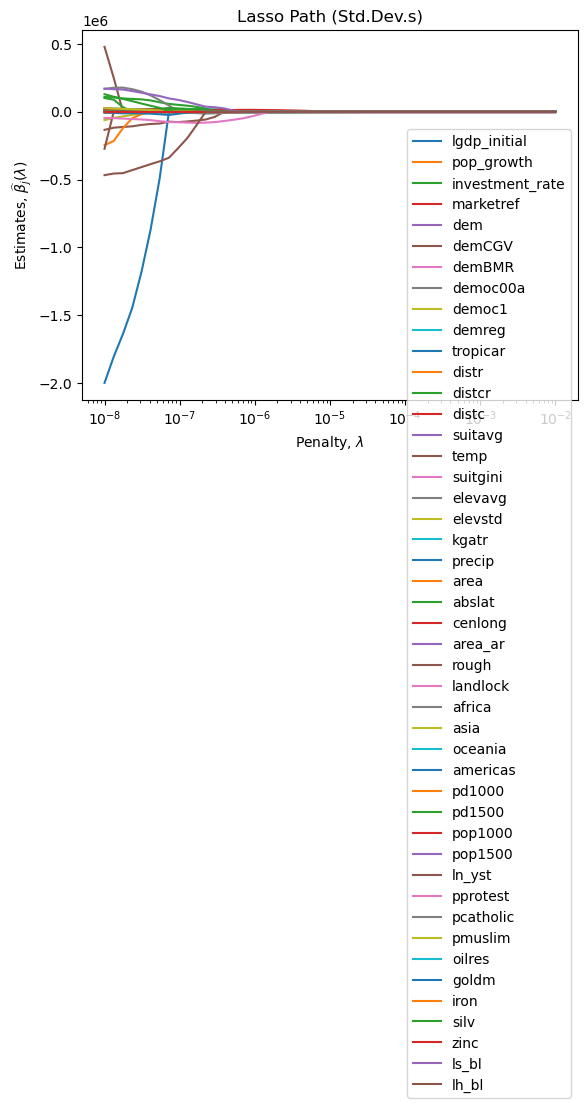

In [21]:
# Plotting coefficients against grid of candidate penalties
ax=plt.gca()

plt.plot(penalty_grid,coefs, label=varnames)

ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1,0.75))
# Adding labels, title, and legend
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
plt.title('Lasso Path (Std.Dev.s)')

# Showing plot
# plt.show()


### Coefficients not equal to zero

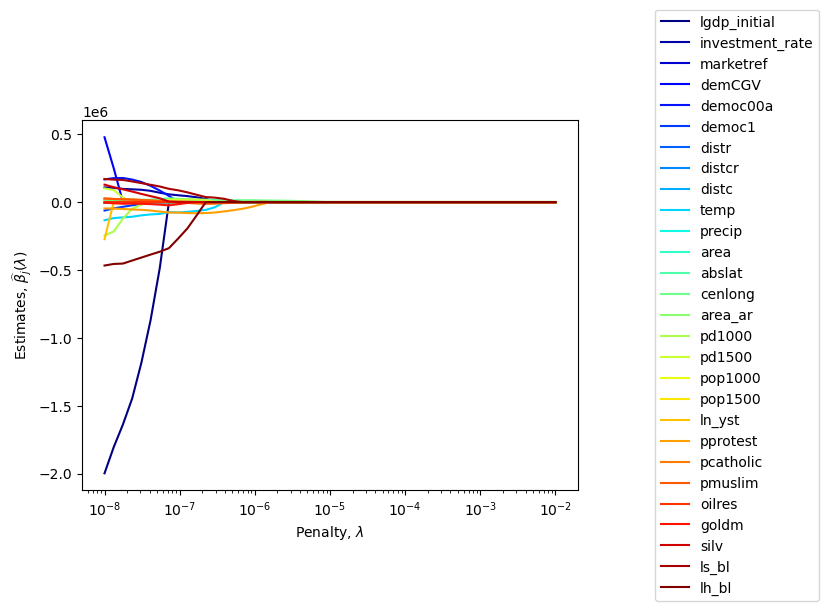

In [22]:
df = pd.DataFrame(dict(zip(penalty_grid,coefs)), index=varnames)
df_no_zeros = df.loc[(df!=0).any(axis=1)].T.plot(logx=True, colormap='jet').legend(loc='center right', bbox_to_anchor=(1.5,0.5))
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
plt.savefig('_draft_fig_lasso.pdf', bbox_inches = "tight")

### 6.2. Lasso with Cross Validation 

Would avoid CV, as we have such a small dataset...

In [23]:
from sklearn.linear_model import LassoCV

clf_cv = LassoCV(cv=5, max_iter=100000)
clf_cv.fit(X_tilde,y.flatten())
coef_CV = clf_cv.coef_
penalty_CV=clf_cv.alpha_

In [24]:
penalty_CV

0.11700075070744427

### 6.3. Lasso with BRT

### 6.4 Lasso with BCCH

## 7. Post-Lasso